<a href="https://colab.research.google.com/github/bbqgonewrong/Stock-Market-Prediction/blob/main/Stock_Prediction_using_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [ ]:
df = pd.read_csv('/content/MSFT.csv')

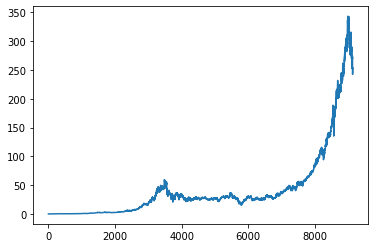

In [ ]:
df.Close.plot()

In [ ]:
#Only using the close value
df = df[['Date','Close']]

#Creating a function in order to convert the date column(stored as string) into date time variable type using a function

In [ ]:
def str_to_datetime(s):
  split = s.split('-')
  year,month,day = int(split[0]),int(split[1]),int(split[2])
  return datetime.datetime(year=year,month=month,day=day)

In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)

In [ ]:
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [ ]:
df.index = df.pop('Date')

In [ ]:
df

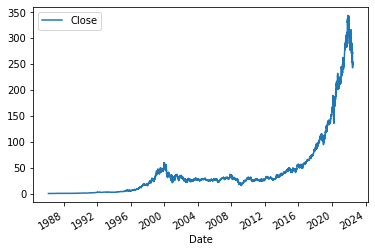

In [ ]:
df.plot()

#Creating target variables by using previous output as next label

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-06-22', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
309,2022-06-15,252.990005,242.259995,244.490005,251.759995
310,2022-06-16,242.259995,244.490005,251.759995,244.970001
311,2022-06-17,244.490005,251.759995,244.970001,247.649994
312,2022-06-21,251.759995,244.970001,247.649994,253.740005


In [ ]:
def windowed_df_to_date_X_y(windowed_df):
  df_as_np = windowed_df.to_numpy()
  dates = df_as_np[:,0]
  middle_matrix = df_as_np[:,1:-1]
  X = middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))
  y = df_as_np[:,-1]
  return dates,X.astype(np.float32),y.astype(np.float32)

In [ ]:
dates,X,y = windowed_df_to_date_X_y(windowed_df)

In [ ]:
dates.shape,X.shape,y.shape

((314,), (314, 3, 1), (314,))

#Splitting the data into Train,Val and Test

In [ ]:
q_80 = int(len(dates)*0.8) #80% of the data
q_90 = int(len(dates)*0.9) #90% of the data

dates_train,X_train,y_train = dates[:q_80],X[:q_80],y[:q_80] 
dates_val,X_val,y_val = dates[q_80:q_90],X[q_80:q_90],y[q_80:q_90]
dates_test,X_test,y_test = dates[q_90:],X[q_90:],y[q_90:] 

Text(0, 0.5, 'Closing Value')

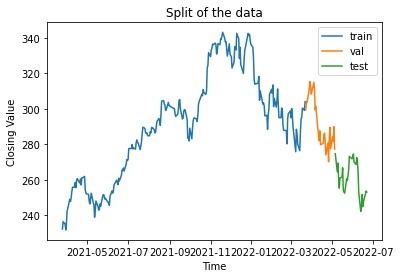

In [ ]:
plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)
plt.legend(['train','val','test'])
plt.title('Split of the data')
plt.xlabel('Time')
plt.ylabel('Closing Value')

#Defining the sequential LSTM model to be used

In [ ]:
model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(64,activation='relu'),
                    layers.Dense(64,activation='relu'),
                    layers.Dense(1,activation='linear')])

model.compile(loss='mse',optimizer = Adam(learning_rate=0.001),metrics = ['mean_absolute_error'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,281
Trainable params: 25,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,validation_data = (X_val,y_val),epochs = 100)

Epoch 1/100
8/8 [==============================] - 3s 77ms/step - loss: 85286.5078 - mean_absolute_error: 290.5950 - val_loss: 85105.2031 - val_mean_absolute_error: 291.4196
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 84734.3594 - mean_absolute_error: 289.6435 - val_loss: 84536.9062 - val_mean_absolute_error: 290.4429
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 84088.6875 - mean_absolute_error: 288.5277 - val_loss: 83789.6953 - val_mean_absolute_error: 289.1539
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 83270.2969 - mean_absolute_error: 287.1015 - val_loss: 82829.0625 - val_mean_absolute_error: 287.4875
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 82080.9609 - mean_absolute_error: 285.0280 - val_loss: 81184.5547 - val_mean_absolute_error: 284.6127
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 80129.9766 - mean_absolute_error: 281.5739 - val_loss: 78867.01

#Assessing the model performance

##Training data

Text(0, 0.5, 'Closing Value')

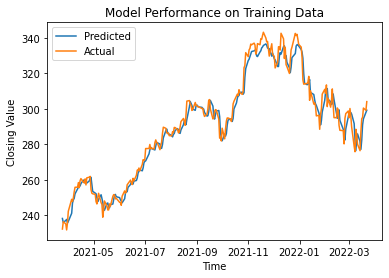

In [ ]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train,train_predictions)
plt.plot(dates_train,y_train)
plt.legend(['Predicted','Actual'])
plt.title('Model Performance on Training Data')
plt.xlabel('Time')
plt.ylabel('Closing Value')

##Validation Data

Text(0, 0.5, 'Closing Value')

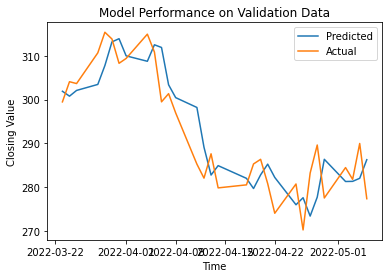

In [ ]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val,val_predictions)
plt.plot(dates_val,y_val)
plt.legend(['Predicted','Actual'])
plt.title('Model Performance on Validation Data')
plt.xlabel('Time')
plt.ylabel('Closing Value')

##Test data

Text(0, 0.5, 'Closing Value')

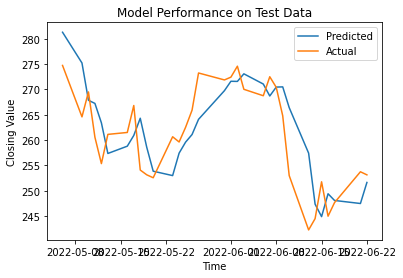

In [ ]:
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test,test_predictions)
plt.plot(dates_test,y_test)
plt.legend(['Predicted','Actual'])
plt.title('Model Performance on Test Data')
plt.xlabel('Time')
plt.ylabel('Closing Value')

LSTMs are not so good at extrapolating data. Thus it's advisable to choose a date closer to the range to predict. It does not make much use of Historic data

#Manually forecasting the future predictions using the data we actually have

In [ ]:
from copy import deepcopy
recursive_predictions = []
recursive_dates = np.concatenate([dates_val,dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

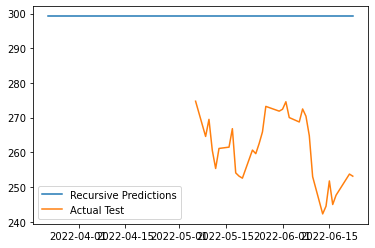

In [ ]:
plt.plot(recursive_dates,recursive_predictions)
plt.plot(dates_test,y_test)
plt.legend(['Recursive Predictions','Actual Test'])
